In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'

non_normalized_data_file = 'missing_outliers_processed_dataset.csv'
normalized_data_file = 'normalized_dataset.csv'
factored_data_file = 'factored_dataset.csv'

data = pd.read_csv(file_dir + normalized_data_file)

In [380]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


## Linear Regression Model

In [381]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.2, random_state=365)

# for better convergence and result scale target to values between 0 - 1
maxltcy = targets.max()
y_train = y_train / maxltcy
y_test = y_test / maxltcy



In [382]:
# standardize the features
scaler = StandardScaler()

# using SelectFromModel metatransformer to select features
clf = LassoCV()
sfm = SelectFromModel(clf, threshold=0.01)

# SVM
svr = LinearSVR(C=0.1, verbose=1)

pline = Pipeline([
    ('scaler', scaler),
    ('feature_selection', sfm),
    ('regression', svr)
])

y_hat = pline.fit(x_train, y_train)

In [383]:
y_hat = pline.predict(x_train)

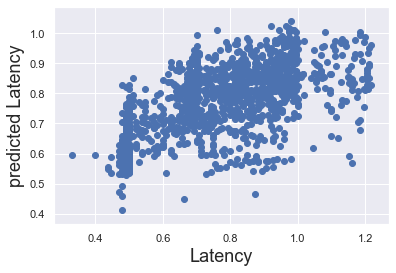

In [384]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

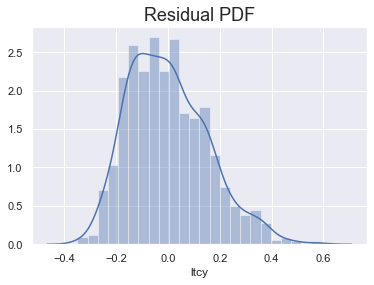

In [385]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [386]:
# R-Squared
pline.score(x_train, y_train)

0.36799525367608044

In [387]:
pline.named_steps.regression.intercept_

0.7757958977904624

In [388]:
pline.named_steps.regression.coef_

array([-0.01210887,  0.03217491,  0.01372001, -0.09774381, -0.01858821,
        0.19282815])

In [389]:
selector = pline.named_steps.feature_selection
selected_features = selector.transform(inputs)
number_of_features = selected_features.shape[1]

features = []
for i in range(number_of_features):
    features.append('Feature_' + str(i))

reg_summary = pd.DataFrame(features, columns=['features'])
reg_summary['weights'] = pline.named_steps.regression.coef_
reg_summary

,features,weights
0,Feature_0,-0.012
1,Feature_1,0.032
2,Feature_2,0.014
3,Feature_3,-0.098
4,Feature_4,-0.019
5,Feature_5,0.193


### Testing

In [390]:
y_hat_test = pline.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

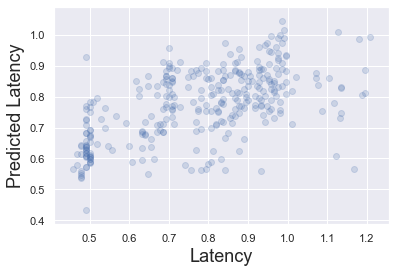

In [391]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [392]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,2.317,1.999
1,2.224,2.014
2,1.970,1.882
3,2.423,2.705
4,2.487,2.071


In [393]:
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,2.317,1.999,0.317,15.867
1,2.224,2.014,0.210,10.452
2,1.970,1.882,0.088,4.667
3,2.423,2.705,-0.282,10.430
4,2.487,2.071,0.416,20.104
...,...,...,...,...
312,2.700,3.348,-0.648,19.355
313,2.499,2.514,-0.015,0.611
314,2.546,2.705,-0.159,5.864
315,2.191,2.664,-0.473,17.759


In [394]:
perf.describe()

,prediction,target,residual,difference%
count,317.000,317.000,317.000,317.000
mean,2.184,2.219,-0.035,11.978
std,0.249,0.410,0.340,8.654
min,1.541,1.581,-1.446,0.010
25%,1.991,1.912,-0.247,5.289
50%,2.187,2.239,0.005,10.598
75%,2.363,2.528,0.204,17.358
max,2.845,3.348,0.903,55.352


In [395]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
232,2.24,2.24,0.00,0.01
303,2.69,2.69,-0.00,0.02
166,2.41,2.40,0.00,0.03
248,2.04,2.04,-0.00,0.13
115,1.98,1.98,-0.00,0.13
53,1.99,1.98,0.00,0.16
308,2.41,2.40,0.00,0.20
49,1.89,1.88,0.00,0.23
105,2.27,2.28,-0.01,0.35
81,2.25,2.25,-0.01,0.36
